## Исследование текущего рейтинга

### Настройки доступа

In [1]:
import yaml, json, boto3, botocore
import psycopg2 as ps
import pandas as pd
import numpy as np

#настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [2]:
# чтение индивидуальных паролей из файла конфигов
def read_yaml_config(yaml_file: str, section: str) -> dict:
    with open(yaml_file, 'r') as yaml_stream:
        descriptor = yaml.full_load(yaml_stream)
        if section in descriptor:
            configuration = descriptor[section]
            return configuration
        else:
            logging.error(f"Section {section} not find in the file '{yaml_file}'")
            sys.exit(1)

# SQL-запрос и вывод в датафрейм            
def get_data(query: str, file='config.yaml', section='chgk_base') -> list:
    settings = read_yaml_config(file, section)
    conn = None
    try:
        conn = ps.connect(**settings)
        cur = conn.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
        df = pd.DataFrame(rows, columns=colnames)
        cur.close()
        conn.close()
        return df
    except (Exception, ps.DatabaseError) as err:
        logging.error(f"PostgreSQL can't execute query - {err}")
    finally:
        if conn is not None:
            conn.close()

In [3]:
# список доступныхтаблиц
get_data("""

SELECT *
FROM
    information_schema.tables
WHERE
   table_schema NOT IN ('pg_catalog', 'information_schema')
   and table_name like '%rating%'
limit 2

""")

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,public,public,rating_venue,BASE TABLE,None,None,None,None,None,YES,NO,None
1,public,public,rating_player,BASE TABLE,None,None,None,None,None,YES,NO,None


In [4]:
# пример вывода таблиц
get_data("""

SELECT *
FROM 
--rating_newrating
--rating_result
--rating_tournament
rating_oldrating
--rating_team
--rating_tournament_orgcommittee
--rating_typeoft
--rating_player
--"rating_result_teamMembers"
--rating_syncrequest
--rating_oldteamrating
where
result_id=426117


--limit 3

""")

,id,rating,usedRating,flag,player_id,result_id
0,2137967,11325,11325,None,24341,426117
1,2137969,10920,9100,Б,26173,426117
2,2137971,10919,7279,Б,60149,426117
3,2137974,10692,5346,Б,20700,426117
4,2137976,10626,3542,К,144,426117
5,2137978,10497,1750,Б,56814,426117


In [5]:
%%time
# базовый запрос, с которым можно решать большую часть задач

base_sql="""
with main as
(
    SELECT
            row_number() over (order by t.start_datetime, pl.id) id
          , t.title tournament
          , main.team_title team
          , main.position
          , main.total
          , pl.last_name
          , pl.first_name
          , pl.patronymic
          , case 
              when ind.flag is null then 'Л'
              else ind.flag
            end flag
          , t.id tournament_id
          , team.id team_id
          , pl.id player_id
          , t.start_datetime
          , t.end_datetime
          , tof.title kind
          , t."questionQty" tournament_distance
          , rtg."inRating" is_rating
          , rtg."predictedPosition" predicted_position
          , rtg.rg predicted_bonus
          , rtg.d rating_result
          , r.result_id team_in_tournament
          , ind.rating individual_rating
          , ind."usedRating" individual_rating_in_tournament
    FROM rating_result main
    left outer join rating_tournament t on
        main.tournament_id=t.id
    left outer join "rating_result_teamMembers" r on
        main.id=r.result_id
    left outer join rating_player pl on
        r.player_id=pl.id
    left outer join rating_team team on
        team.id=main.team_id
    left outer join rating_oldteamrating rtg on
        r.result_id=rtg.result_id
    left outer join rating_typeoft tof on
        tof.id=t.typeoft_id
    left outer join rating_oldrating ind on
        ind.result_id=r.result_id and
        ind.player_id=pl.id
    where 
    t.start_datetime>='2018-01-01' and
    t.end_datetime<='2020-03-01' and
    rtg."inRating"=True
)


"""

# смотрим состав одной команды одного турнира
get_data(base_sql+"""
select *
from main
where tournament_id=5465 and team_id=407
limit 80

""")

CPU times: user 16.7 ms, sys: 78 µs, total: 16.8 ms
Wall time: 16.8 s


,id,tournament,team,position,total,last_name,first_name,patronymic,flag,tournament_id,team_id,player_id,start_datetime,end_datetime,kind,tournament_distance,is_rating,predicted_position,predicted_bonus,rating_result,team_in_tournament,individual_rating,individual_rating_in_tournament
0,411168,Чемпионат России,Тачанка,8.5,49,Абрамов,Сергей,Леонидович,К,5465,407,144,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,10626,3542
1,411323,Чемпионат России,Тачанка,8.5,49,Мерзляков,Максим,Петрович,Б,5465,407,20700,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,10692,5346
2,411352,Чемпионат России,Тачанка,8.5,49,Пахомов,Даниил,Владимирович,Л,5465,407,24341,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,11325,11325
3,411364,Чемпионат России,Тачанка,8.5,49,Прохин,Алексей,Викторович,Б,5465,407,26173,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,10920,9100
4,411525,Чемпионат России,Тачанка,8.5,49,Пономарёв,Дмитрий,Александрович,Б,5465,407,56814,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,10497,1750
5,411534,Чемпионат России,Тачанка,8.5,49,Челышев,Сергей,Михайлович,Б,5465,407,60149,2019-05-18 09:00:00+00:00,2019-05-19 15:00:00+00:00,Обычный,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",True,13,7790,239,426117,10919,7279


## Начало исследований

### Турниры в целом

In [56]:
%%time
# метрики в целом по датасету
get_data(base_sql+"""
select count(distinct tournament_id) tournaments
        , count(distinct team_id) total_teams
        , count(distinct team_in_tournament) team_games 
        , count(distinct player_id) players 
        , count(distinct id) player_games 
        , cast(count(distinct team_in_tournament) as float)/count(distinct team_id) games_per_team
        , cast(count(distinct id) as float)/count(distinct player_id) games_per_player
        , cast(count(distinct team_in_tournament) as float)/count(distinct tournament_id) teams_per_tournament
        , cast(count(distinct id) as float)/count(distinct tournament_id) players_per_tournament
        , cast(count(distinct id) as float)/count(distinct team_in_tournament) players_per_team_in_tornament
        , cast(count(distinct player_id)as float)/count(distinct team_id) players_per_team_in_general
        
        
from main



""").T

CPU times: user 13.7 ms, sys: 272 µs, total: 13.9 ms
Wall time: 8.24 s


,0
tournaments,1360.000000
total_teams,8965.000000
team_games,120190.000000
players,64485.000000
player_games,647617.000000
games_per_team,13.406581
games_per_player,10.042909
teams_per_tournament,88.375000
players_per_tournament,476.188971
players_per_team_in_tornament,5.388277


In [6]:
%%time
# разбивка по типу турниров
df_kind=get_data(base_sql+"""
select kind
        , count(distinct tournament_id) tournaments
        , count(distinct team_id) total_teams
        , count(distinct team_in_tournament) team_games 
        , count(distinct player_id) players 
        , count(distinct id) player_games 
        , cast(count(distinct team_in_tournament) as float)/count(distinct team_id) games_per_team
        , cast(count(distinct id) as float)/count(distinct player_id) games_per_player
        , cast(count(distinct team_in_tournament) as float)/count(distinct tournament_id) teams_per_tournament
        , cast(count(distinct id) as float)/count(distinct tournament_id) players_per_tournament
        , cast(count(distinct id) as float)/count(distinct team_in_tournament) players_per_team_in_tornament
        , cast(count(distinct player_id)as float)/count(distinct team_id) players_per_team_in_general
        
        
from main
group by 1
order by 2 desc


""")

CPU times: user 8.2 ms, sys: 30 µs, total: 8.23 ms
Wall time: 10.2 s


In [7]:
df_kind.set_index('kind')

,tournaments,total_teams,team_games,players,player_games,games_per_team,games_per_player,teams_per_tournament,players_per_tournament,players_per_team_in_tornament,players_per_team_in_general
kind,,,,,,,,,,,
Синхрон,739,6439,99887,48134,530856,15.512813,11.028712,135.165088,718.343708,5.314565,7.475384
Обычный,537,3913,13179,25730,78944,3.368004,3.068169,24.541899,147.009311,5.990136,6.575518
Асинхрон,73,2903,6632,17564,34944,2.284533,1.989524,90.849315,478.684932,5.268999,6.050293
Строго синхронный,11,343,492,2056,2873,1.434402,1.397374,44.727273,261.181818,5.839431,5.994169


In [57]:
df_kind.set_index('kind')[['players_per_team_in_tornament']]

,players_per_team_in_tornament
kind,
Синхрон,5.314565
Обычный,5.990136
Асинхрон,5.268999
Строго синхронный,5.839431


In [10]:
%%time
# разбивка по турнирной дистанции
df_dist=get_data(base_sql+"""
select tournament_distance
        , count(distinct tournament_id) tournaments
        , count(distinct team_id) total_teams
        , count(distinct team_in_tournament) team_games 
        , count(distinct player_id) players 
        , count(distinct id) player_games 
        , cast(count(distinct team_in_tournament) as float)/count(distinct team_id) games_per_team
        , cast(count(distinct id) as float)/count(distinct player_id) games_per_player
        , cast(count(distinct team_in_tournament) as float)/count(distinct tournament_id) teams_per_tournament
        , cast(count(distinct id) as float)/count(distinct tournament_id) players_per_tournament
        , cast(count(distinct id) as float)/count(distinct team_in_tournament) players_per_team_in_tornament
        , cast(count(distinct player_id)as float)/count(distinct team_id) players_per_team_in_general
        
        
from main
group by 1
order by 2 desc


""")

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 12 s


In [11]:
df_dist

,tournament_distance,tournaments,total_teams,team_games,players,player_games,games_per_team,games_per_player,teams_per_tournament,players_per_tournament,players_per_team_in_tornament,players_per_team_in_general
0,"{""1"": 12, ""2"": 12, ""3"": 12}",696,7760,85555,55044,453091,11.025129,8.231433,122.923851,650.992816,5.295903,7.093299
1,"{""1"": 15, ""2"": 15, ""3"": 15}",141,2619,9636,17110,53032,3.679267,3.099474,68.340426,376.113475,5.503528,6.533028
2,"{""1"": 13, ""2"": 13, ""3"": 13}",53,1394,3397,8761,18216,2.436872,2.079215,64.094340,343.698113,5.362379,6.284792
3,"{""1"": 12, ""2"": 12, ""3"": 12, ""4"": 12}",53,2197,6265,14161,34358,2.851616,2.426241,118.207547,648.264151,5.484118,6.445608
4,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15, ""6"": 15}",53,1042,1946,6898,12208,1.867562,1.769788,36.716981,230.339623,6.273381,6.619962
5,"{""1"": 12, ""2"": 12, ""3"": 12, ""4"": 12, ""5"": 12, ""6"": 12}",53,827,1263,5308,7702,1.527207,1.451017,23.830189,145.320755,6.098179,6.418380
6,"{""1"": 18, ""2"": 18}",52,551,1826,3411,9756,3.313975,2.860158,35.115385,187.615385,5.342826,6.190563
7,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15}",50,805,1345,5085,7968,1.670807,1.566962,26.900000,159.360000,5.924164,6.316770
8,"{""1"": 15, ""2"": 15, ""3"": 15, ""4"": 15, ""5"": 15}",39,812,1338,5200,8280,1.647783,1.592308,34.307692,212.307692,6.188341,6.403941
9,"{""1"": 12, ""2"": 12, ""3"": 12, ""4"": 12, ""5"": 12}",27,523,766,3209,4492,1.464627,1.399813,28.370370,166.370370,5.864230,6.135755


In [12]:
%%time
# годовая динамика
df_dyn_y=get_data(base_sql+"""
select date_part('year', start_datetime) y
        , count(distinct tournament_id) tournaments
        , count(distinct team_id) total_teams
        , count(distinct team_in_tournament) team_games 
        , count(distinct player_id) players 
        , count(distinct id) player_games 
        , cast(count(distinct team_in_tournament) as float)/count(distinct team_id) games_per_team
        , cast(count(distinct id) as float)/count(distinct player_id) games_per_player
        , cast(count(distinct team_in_tournament) as float)/count(distinct tournament_id) teams_per_tournament
        , cast(count(distinct id) as float)/count(distinct tournament_id) players_per_tournament
        , cast(count(distinct id) as float)/count(distinct team_in_tournament) players_per_team_in_tornament
        , cast(count(distinct player_id)as float)/count(distinct team_id) players_per_team_in_general
        
        
from main
group by 1
order by 1


""")

CPU times: user 6.15 ms, sys: 284 µs, total: 6.43 ms
Wall time: 8.61 s


In [13]:
df_dyn_y

,y,tournaments,total_teams,team_games,players,player_games,games_per_team,games_per_player,teams_per_tournament,players_per_tournament,players_per_team_in_tornament,players_per_team_in_general
0,2018.0,602,6209,51916,43061,280274,8.361411,6.508767,86.239203,465.571429,5.398605,6.935255
1,2019.0,660,5879,58322,41677,313649,9.920395,7.525710,88.366667,475.225758,5.377885,7.089131
2,2020.0,98,2616,9952,16984,53694,3.804281,3.161446,101.551020,547.897959,5.395297,6.492355


In [14]:
%%time
# месячная динамика
df_dyn_m=get_data(base_sql+"""
select date_part('year', start_datetime) y
        , date_part('month', start_datetime) m
        , concat(date_part('year', start_datetime), '-', date_part('month', start_datetime) ) period
        , count(distinct tournament_id) tournaments
        , count(distinct team_id) total_teams
        , count(distinct team_in_tournament) team_games 
        , count(distinct player_id) players 
        , count(distinct id) player_games 
        , cast(count(distinct team_in_tournament) as float)/count(distinct team_id) games_per_team
        , cast(count(distinct id) as float)/count(distinct player_id) games_per_player
        , cast(count(distinct team_in_tournament) as float)/count(distinct tournament_id) teams_per_tournament
        , cast(count(distinct id) as float)/count(distinct tournament_id) players_per_tournament
        , cast(count(distinct id) as float)/count(distinct team_in_tournament) players_per_team_in_tornament
        , cast(count(distinct player_id)as float)/count(distinct team_id) players_per_team_in_general
        
        
from main
group by 1,2
order by 1,2


""")

CPU times: user 9.95 ms, sys: 234 µs, total: 10.2 ms
Wall time: 9.5 s


In [15]:
df_dyn_m[0:3]

,y,m,period,tournaments,total_teams,team_games,players,player_games,games_per_team,games_per_player,teams_per_tournament,players_per_tournament,players_per_team_in_tornament,players_per_team_in_general
0,2018.0,1.0,2018-1,26,1630,3547,9836,19121,2.176074,1.943981,136.423077,735.423077,5.390753,6.034356
1,2018.0,2.0,2018-2,50,2095,4666,12590,25313,2.227208,2.010564,93.320000,506.260000,5.424989,6.009547
2,2018.0,3.0,2018-3,65,2247,5861,14000,31594,2.608367,2.256714,90.169231,486.061538,5.390548,6.230530


tournaments
total_teams
team_games
players
player_games
games_per_team
games_per_player
teams_per_tournament
players_per_tournament
players_per_team_in_tornament
players_per_team_in_general


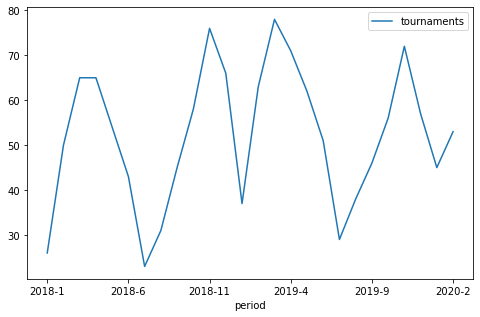

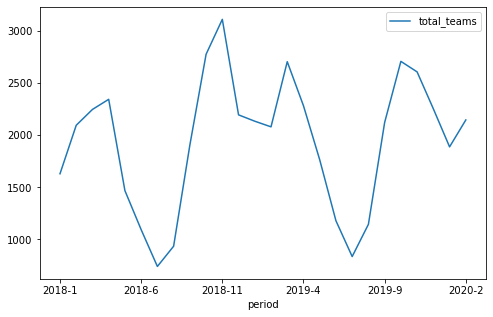

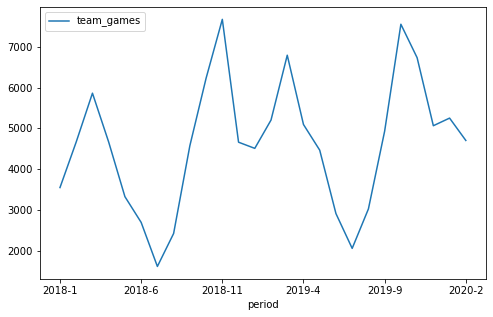

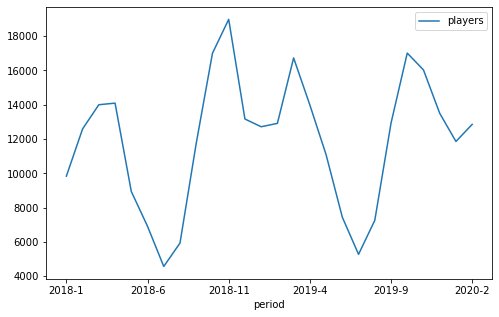

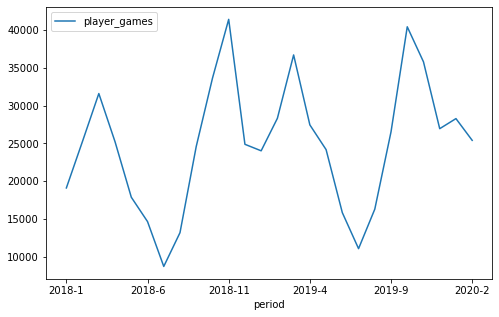

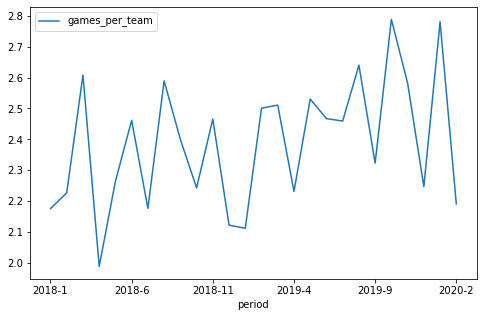

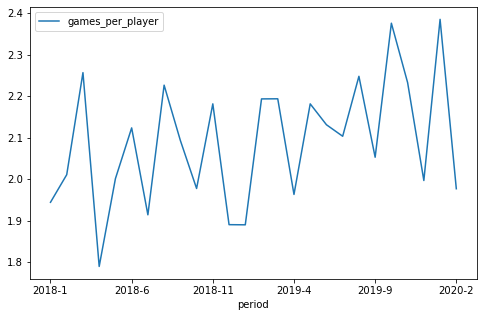

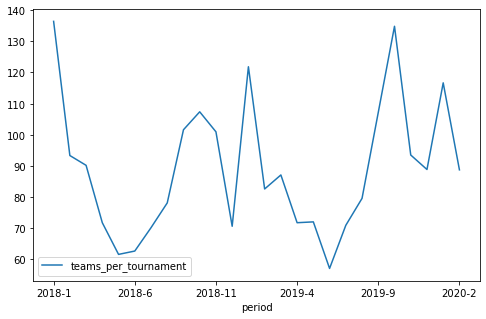

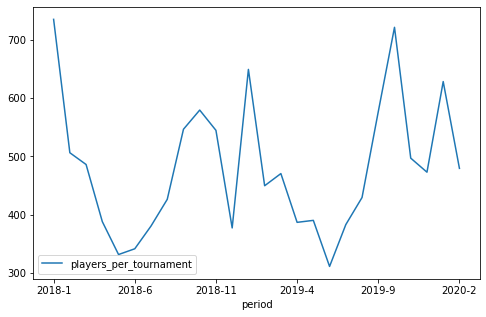

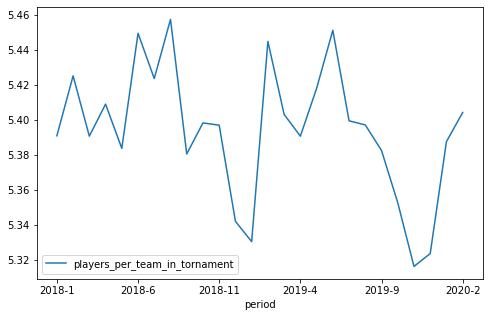

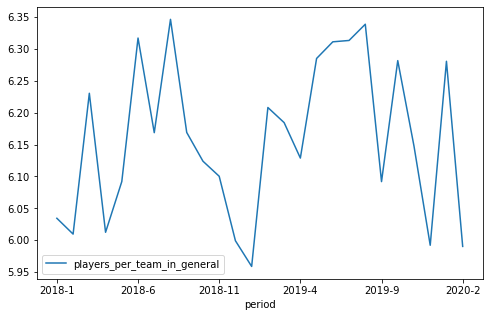

In [16]:
for col in df_dyn_m.columns[3:]:
    print(col)
    df_dyn_m.set_index('period')[[col]].plot()

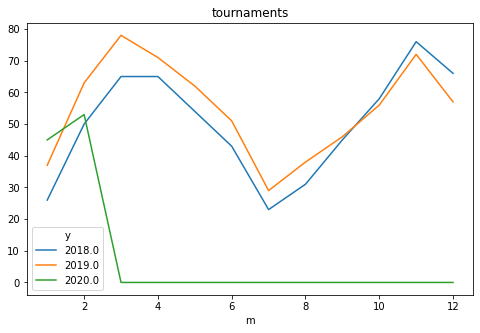

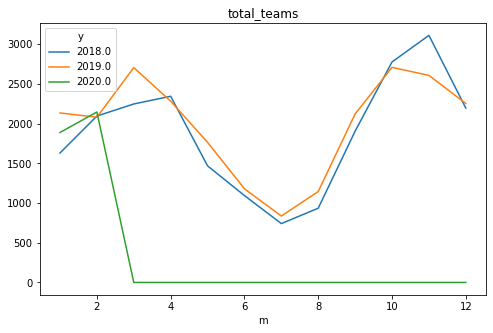

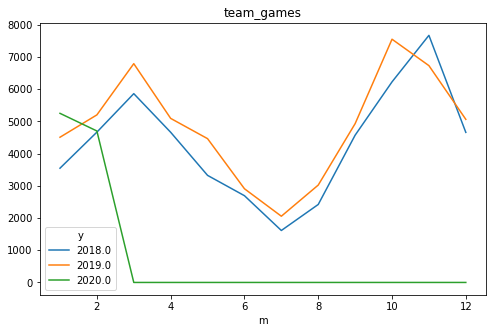

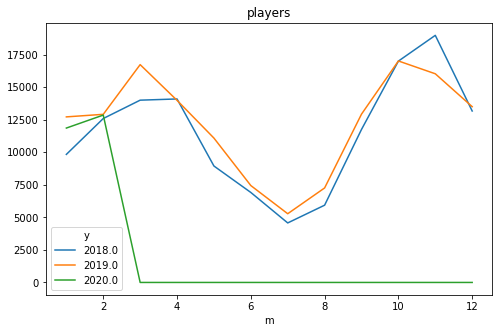

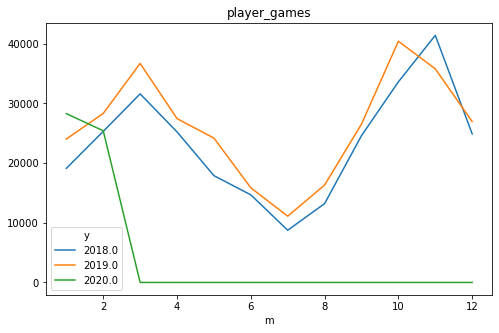

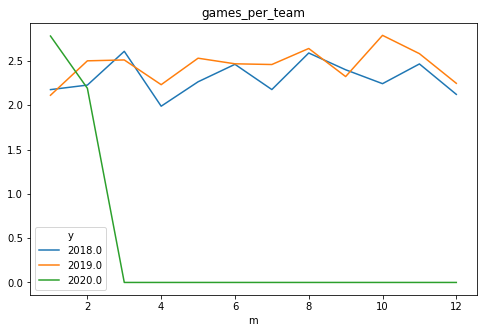

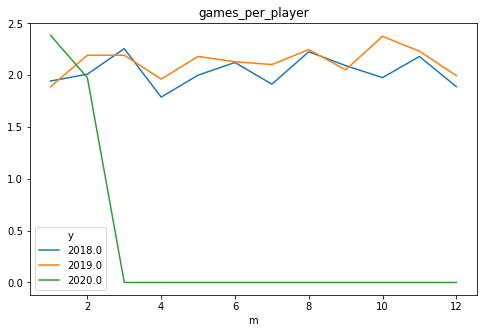

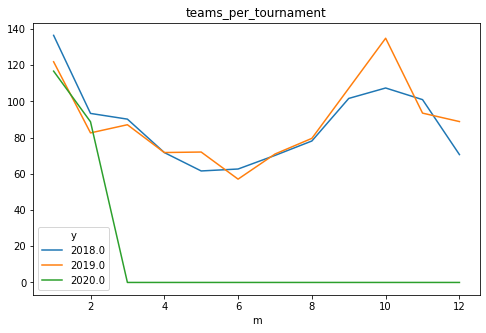

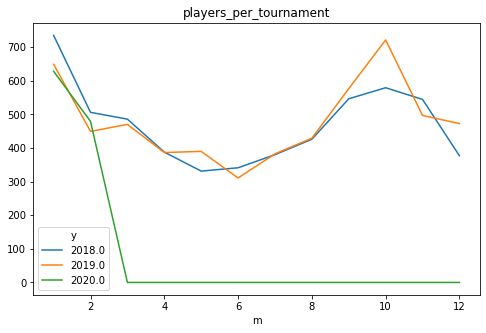

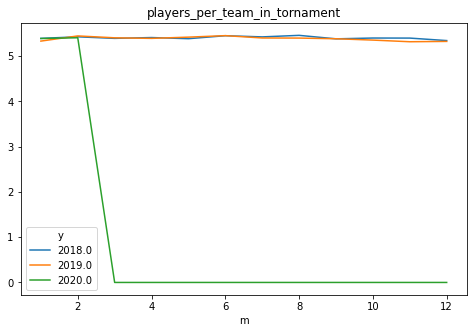

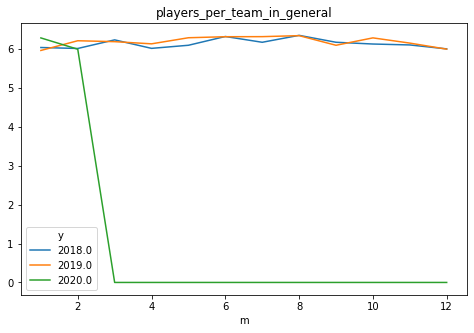

In [17]:
for col in df_dyn_m.columns[3:]:
    pv=df_dyn_m.pivot_table(index='m', 
                            columns='y', 
                            values=col).fillna(0)
    pv.plot(title=col)

### Распределение игр команд

In [18]:
%%time
# команды и их игры
team_distr=get_data(base_sql+"""
, teams_stat as
(
    select team_id, count(distinct team_in_tournament) num
    from main
    group by 1
)

select num, count(distinct team_id) teams
from teams_stat 
group by 1
order by 1




""")
# доля команд, которые сыграли ровно столько игр от общего числа играющих
team_distr['share']=team_distr['teams']/np.sum(team_distr['teams'])
# доля команд, которые сыграли определённое число игр или меньше
team_distr['cum_share']=np.cumsum(team_distr['share'])

CPU times: user 11.8 ms, sys: 211 µs, total: 12 ms
Wall time: 5.4 s


In [19]:
# медиана по активности
team_distr[team_distr['cum_share']>=0.5][['num', 'cum_share']][0:1]

,num,cum_share
2,3,0.555159


In [20]:
# 75-й процентиль
team_distr[team_distr['cum_share']>=0.75][['num', 'cum_share']][0:1]

,num,cum_share
10,11,0.759509


In [21]:
team_distr[team_distr['cum_share']>=0.9][['num', 'cum_share']][0:1]

,num,cum_share
39,40,0.902064


In [22]:
team_distr[team_distr['cum_share']>=0.99][['num', 'cum_share']][0:1]

,num,cum_share
136,137,0.990073


<AxesSubplot:xlabel='num'>

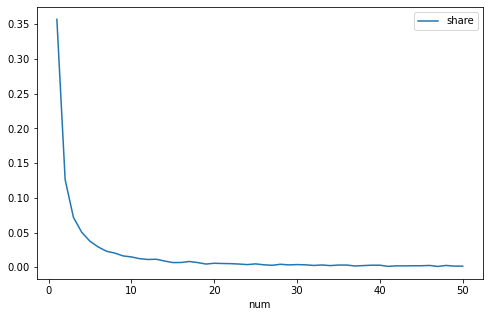

In [23]:
team_distr.set_index('num')[['share']][0:50].plot()

### Бонусы рейтинга Б

In [24]:
%%time
# команды и их бонусы
total_bonuses=get_data(base_sql+"""

select rating_result, count(distinct team_in_tournament) teams
from main
group by 1
order by 1

""")
# нормируем бонусы на число команд
total_bonuses['share']=total_bonuses['teams']/np.sum(total_bonuses['teams'])


CPU times: user 10.6 ms, sys: 346 µs, total: 11 ms
Wall time: 5.58 s


In [25]:
len(total_bonuses)

1083

In [26]:
total_bonuses[0:3]

,rating_result,teams,share
0,-552,1,0.000008
1,-521,1,0.000008
2,-520,1,0.000008


In [27]:
total_bonuses.describe()

,rating_result,teams,share
count,1083.000000,1083.000000,1083.000000
mean,190.450600,110.978763,0.000923
std,345.882391,249.006875,0.002072
min,-552.000000,1.000000,0.000008
25%,-90.500000,2.000000,0.000017
50%,180.000000,12.000000,0.000100
75%,450.500000,126.000000,0.001048
max,1367.000000,5399.000000,0.044921


In [28]:
# доля исходов в минус
np.sum(total_bonuses[total_bonuses['rating_result']<=0]['share'])

0.4706131957733589

In [29]:
# средний бонус в минус
np.median(total_bonuses[total_bonuses['rating_result']<=0]['rating_result'])

-180.5

In [30]:
# средний бонус в плюс
np.median(total_bonuses[total_bonuses['rating_result']>0]['rating_result'])

361.0

In [31]:
# самый частый исход
total_bonuses[total_bonuses['share']==np.max(total_bonuses['share'])]

,rating_result,teams,share
361,0,5399,0.044921


<AxesSubplot:xlabel='rating_result'>

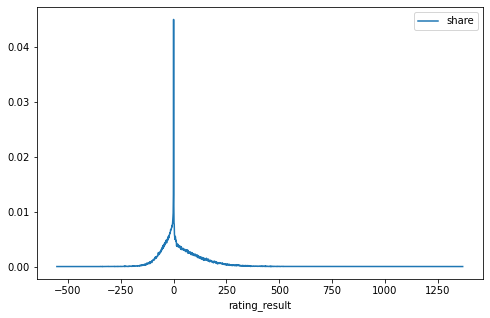

In [32]:
total_bonuses.set_index('rating_result')[['share']].plot()

<AxesSubplot:xlabel='rating_result'>

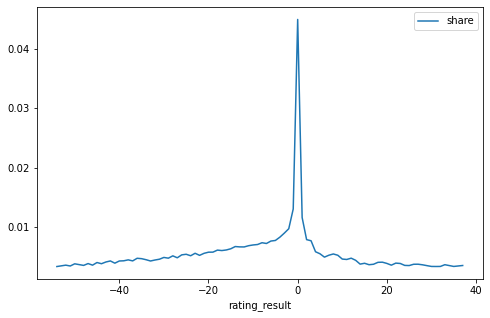

In [33]:
total_bonuses[total_bonuses['teams']>400].set_index('rating_result')[['share']].plot()

In [34]:
# кластеры бонусов - десятичные логарифмы номинала бонусов с соответствующими знаками
total_bonuses['cluster']=np.where(
                            total_bonuses['rating_result']<=0, -1*np.log10(-1*total_bonuses['rating_result']),
                            np.log10(total_bonuses['rating_result'])
                                 )
total_bonuses['cluster']=np.round(total_bonuses['cluster'],1)
rating_clusters=total_bonuses.groupby('cluster').sum()[['teams']]

/home/roman/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/roman/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='cluster'>

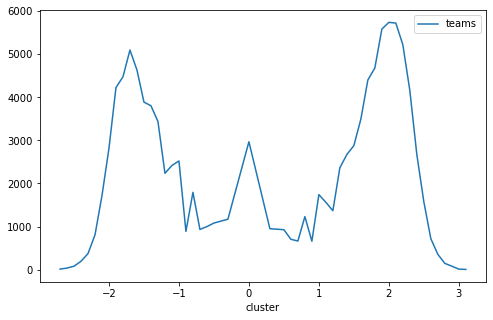

In [35]:
rating_clusters.plot()

In [36]:
pd.DataFrame(total_bonuses['cluster'].value_counts()).head(10)

,cluster
2.7,108
2.6,92
2.8,89
2.5,73
2.9,60
2.4,58
-2.4,53
2.3,46
-2.3,45
-2.5,43


### Фактор легионеров

In [37]:
%%time
# доля легионеров команде
leg_teams_df=get_data(base_sql+"""
, flags as 
(
    select 
            case 
                when (flag='Б') or (flag='К') then 'Б'
                when flag is null then 'Л'
                else flag
              end flag
            , case
                when flag='Л' then 1
                else 0
              end is_leg
            , team_id
            , team_in_tournament
            , count(distinct player_id) players
    from main
    group by 1,2,3,4
)
, totals as 
(
    select team_id
            , team_in_tournament
            , count(distinct player_id) players
    from main
    group by 1,2
)
, base as
(
    select f.*
            , t.players total_players
            , case
                when flag='Л' then cast(f.players as float)/t.players
                else 1-cast(f.players as float)/t.players
              end leg_share
    from flags f
    left outer join totals t on
        f.team_in_tournament=t.team_in_tournament
)
, full_data as 
(
    select distinct team_id, team_in_tournament, leg_share, total_players
    from base
)

select fd.*
    , case
        when leg_share>=0.5 then 1
        else 0
     end is_combine
    , rtg.d rating_result
    , case
        when rtg.d>0 then 1
        else 0
      end is_positive_result
from full_data fd
left outer join rating_oldteamrating rtg on
        fd.team_in_tournament=rtg.result_id

        

"""
)

CPU times: user 527 ms, sys: 70.6 ms, total: 598 ms
Wall time: 29.8 s


In [38]:
len(leg_teams_df)

165984

In [39]:
leg_teams_df.sample(3)

,team_id,team_in_tournament,leg_share,total_players,is_combine,rating_result,is_positive_result
96525,55924,365058,0.250000,4,0,-4,0
100380,45365,601796,0.333333,6,0,-58,0
90579,50807,511433,0.166667,6,0,-74,0


In [40]:
leg_teams_df.describe()

,team_id,team_in_tournament,leg_share,total_players,is_combine,rating_result,is_positive_result
count,165984.000000,165984.000000,165984.000000,165984.000000,165984.000000,165984.000000,165984.000000
mean,44113.656178,418241.487939,0.171885,5.503320,0.042335,32.873162,0.533383
std,23009.863148,111757.727945,0.148051,0.867148,0.201354,103.293547,0.498886
min,2.000000,182346.000000,0.000000,3.000000,0.000000,-552.000000,0.000000
25%,37591.000000,360954.000000,0.000000,5.000000,0.000000,-27.000000,0.000000
50%,51654.000000,424344.500000,0.166667,6.000000,0.000000,5.000000,1.000000
75%,60319.000000,491312.000000,0.333333,6.000000,0.000000,79.000000,1.000000
max,80481.000000,603400.000000,1.000000,14.000000,1.000000,1367.000000,1.000000


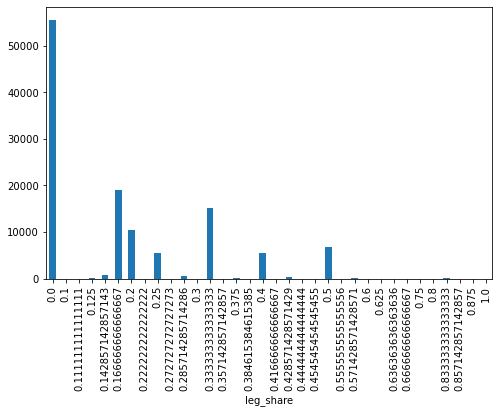

In [41]:
# общая разбивка
leg_distr=leg_teams_df.groupby('leg_share').agg(
                {
                    'team_in_tournament': lambda x: x.nunique(),
                    'team_id': lambda x: x.nunique(),
                })
leg_distr['team_in_tournament'].plot(kind='bar')
leg_distr=leg_distr.reset_index()

In [42]:
# доля игр с легионерами
np.sum(leg_distr[leg_distr['leg_share']==0]['team_in_tournament'])/np.sum(leg_distr['team_in_tournament'])

0.46203511107413264

In [43]:
# доля rкоманд, которые никогда в жизни не играли с легионерами
np.sum(leg_distr[leg_distr['leg_share']==0]['team_id'])/np.sum(leg_distr['team_id'])

0.3136399849050275

<AxesSubplot:xlabel='leg_share', ylabel='rating_result'>

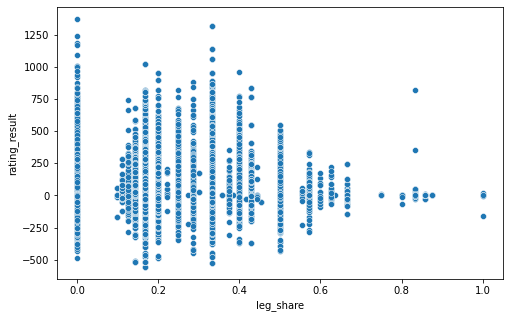

In [44]:
import seaborn as sns
sns.scatterplot(data=leg_teams_df, x='leg_share', y='rating_result')

In [45]:
from scipy import stats
stats.pearsonr(leg_teams_df['leg_share'], leg_teams_df['rating_result'])[0]

0.0152451812995935

### Фактор сборных

In [46]:
# общее число выступлений сборных
leg_teams_df[leg_teams_df['is_combine']==1]['team_in_tournament'].nunique()

6994

In [47]:
# общее число выступлений команда 50 на 50
leg_teams_df[leg_teams_df['leg_share']==0.5]['team_in_tournament'].nunique()

6710

In [48]:
# доля сборных
leg_teams_df[leg_teams_df['is_combine']==1]['team_in_tournament'].nunique()/leg_teams_df['team_in_tournament'].nunique()

0.0581911972709876

In [49]:
# результативность сборных по сравнению с остальными
comb_res=leg_teams_df.groupby(['is_combine', 'rating_result']).agg(
                {
                    'team_in_tournament': lambda x: x.nunique(),
                }).reset_index()

comb_pv=comb_res.pivot_table(index='rating_result', columns='is_combine', values='team_in_tournament').fillna(0).reset_index()

<AxesSubplot:label='90bbebca-47e4-4e7a-b803-56f3d1fe463b'>

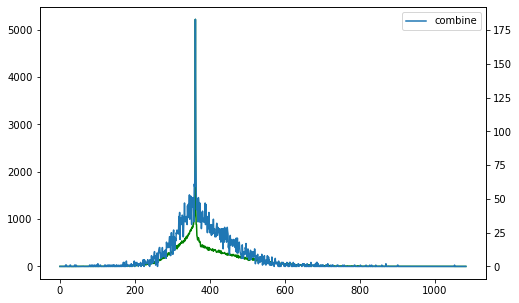

In [50]:
# сборных на фоне остальных команд
comb_pv.columns=['rating_result','simple', 'combine']
ax1 = comb_pv['simple'].plot(color='green')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
comb_pv['combine'].plot(ax=ax2, legend=True)

### Фактор неполных составов

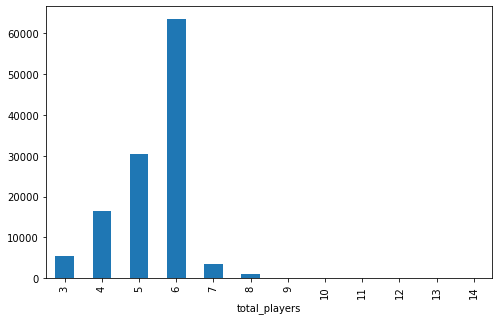

In [51]:
# общая разбивка
num_distr=leg_teams_df.groupby('total_players').agg(
                {
                    'team_in_tournament': lambda x: x.nunique(),
                    'team_id': lambda x: x.nunique(),
                })
num_distr['team_in_tournament'].plot(kind='bar')
num_distr=num_distr.reset_index()

<AxesSubplot:xlabel='total_players', ylabel='rating_result'>

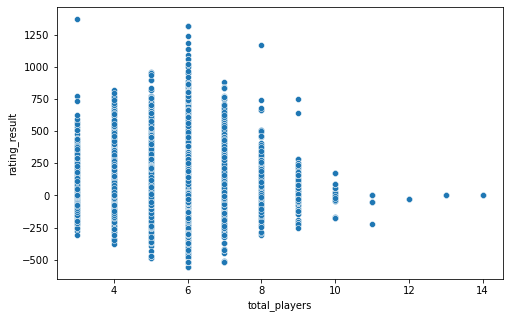

In [52]:
sns.scatterplot(data=leg_teams_df, x='total_players', y='rating_result')

In [53]:
# общая разбивка
num_m=leg_teams_df.groupby('total_players').agg(
                {
                    'rating_result':[np.mean, np.std]
                })


In [54]:
num_m[0:6]

rating_result            
                       mean         std
total_players                          
3                 27.046658   91.156670
4                 29.075510   95.545813
5                 29.910637   99.316266
6                 34.970381  105.419140
7                 36.037736  124.136480
8                 31.370569  121.323850